<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Code Readability Evals</h1>

Arize provides tooling to evaluate LLM applications, including tools to determine the readability or unreadability of code generated by LLM applications. 

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to classifying generated code as readable or unreadable using datasets with ground-truth labels
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [ ]:
!pip install -qq "arize-phoenix[experimental]==0.0.33rc6" ipython matplotlib openai pycm scikit-learn

In [1]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
from phoenix.experimental.evals import (
    CODE_READABILITY_PROMPT_OUTPUT_MAP,
    CODE_READABILITY_PROMPT_TEMPLATE_STR,
    OpenAiModel,
    download_benchmark_dataset,
    llm_eval_binary,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in addition to an evaluation prompt template against benchmark datasets of queries and retrieved documents with ground-truth relevance labels. Currently supported datasets include:

- "wiki_qa-train"
- "ms_marco-v1.1-train"
- "code-readability-classification"

for the code-readability-classification dataset below, we'll randomly select either the "canonical_solution" or the "unreadable_solution" and set the "ground_truth" label to 1 if we selected the canonical solution and 0 if we selected the unreadable solution

In [2]:
# dataset_name = "openai_humaneval_readability"
# df = download_benchmark_dataset(
#     task="code-readability-classification", dataset_name=dataset_name
# )
from zipfile import ZipFile
import pandas as pd
import gzip
import json
with gzip.open("/Users/harrisonchu/Downloads/openai_humaneval_with_readability.jsonl.zipped") as jsonl_file:
    df = pd.DataFrame(map(json.loads, jsonl_file.readlines()))
df.head()

,Unnamed: 0,task_id,prompt,canonical_solution,test,entry_point,readable,solution
0,0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ...","\n\nMETADATA = {\n 'author': 'jt',\n 'da...",has_close_elements,True,"for idx, elem in enumerate(numbers):\n ..."
1,1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,result = []\n current_string = []\n ...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",separate_paren_groups,True,result = []\n current_string = []\n ...
2,2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,return number % 1.0\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",truncate_number,False,return((lambda x: (lambda y: y(x))(lambda f: (...
3,3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,balance = 0\n\n for op in operations:\n...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",below_zero,True,balance = 0\n\n for op in operations:\n...
4,4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,mean = sum(numbers) / len(numbers)\n re...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",mean_absolute_deviation,True,mean = sum(numbers) / len(numbers)\n re...


## Display Binary Relevance Classification Template

View the default template used to classify relevance. You can tweak this template and evaluate its performance relative to the default.

In [4]:
print(CODE_READABILITY_PROMPT_TEMPLATE_STR)


You are a stern but practical senior software engineer who cares a lot about simplicity and
readability of code. Can you review the following code that was written by another engineer?
Focus on readability of the code. Respond with "readable" if you think the code is readable,
or "unreadable" if the code is unreadable or needlessly complex for what it's trying
to accomplish.

ONLY respond with "readable" or "unreadable"

Task Assignment:
```
{query}
```

Implementation to Evaluate:
```
{code}
```



The template variables are:

- **query_text:** the coding task asked by a user
- **code:** implementation of the coding task

## Configure the LLM

Configure your OpenAI API key.

In [19]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

Instantiate the LLM and set parameters.

In [12]:
model = OpenAiModel(
    model_name="gpt-4",
    temperature=0.0,
)

## Run Relevance Classifications

Run relevance classifications against a subset of the data.

In [13]:
df = df.sample(n=100).reset_index(drop=True)
df = df.rename(
    columns={
        "prompt": "query",
        "solution": "code"
    },
)

In [14]:
relevance_classifications = llm_eval_binary(
    dataframe=df,
    template=CODE_READABILITY_PROMPT_TEMPLATE_STR,
    model=model,
    rails=list(CODE_READABILITY_PROMPT_OUTPUT_MAP.values()),
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


## Evaluate Classifications

Evaluate the predictions against human-labeled ground-truth relevance labels.

              precision    recall  f1-score   support

    readable       0.93      0.69      0.79        55
  unreadable       0.71      0.93      0.81        45

    accuracy                           0.80       100
   macro avg       0.82      0.81      0.80       100
weighted avg       0.83      0.80      0.80       100



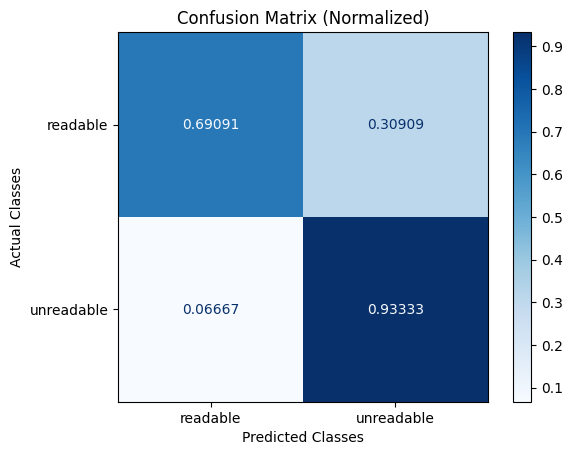

In [15]:
true_labels = df["readable"].map(CODE_READABILITY_PROMPT_OUTPUT_MAP).tolist()
predicted_labels = relevance_classifications
classes = list(CODE_READABILITY_PROMPT_OUTPUT_MAP.values())

print(classification_report(true_labels, predicted_labels, labels=classes))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=predicted_labels, classes=classes
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
);

## Inspecting evaluations

Because the evals are binary classifications, we can easily sample a few rows where the evals deviated from ground truth and see what the actual code was in that case.

In [18]:
df['predicted'] = predicted_labels
# inspect instances where ground truth was readable but evaluated to unreadable by the LLM
filtered_df = df.query('readable == True and predicted == "unreadable"')

# inspect first 5 rows that meet this condition
pd.set_option('display.max_colwidth', None)
result = filtered_df.head(5)
result

,Unnamed: 0,task_id,query,canonical_solution,test,entry_point,readable,code,predicted
3,129,HumanEval/129,"\ndef minPath(grid, k):\n """"""\n Given a grid with N rows and N columns (N >= 2) and a positive integer k, \n each cell of the grid contains a value. Every integer in the range [1, N * N]\n inclusive appears exactly once on the cells of the grid.\n\n You have to find the minimum path of length k in the grid. You can start\n from any cell, and in each step you can move to any of the neighbor cells,\n in other words, you can go to cells which share an edge with you current\n cell.\n Please note that a path of length k means visiting exactly k cells (not\n necessarily distinct).\n You CANNOT go off the grid.\n A path A (of length k) is considered less than a path B (of length k) if\n after making the ordered lists of the values on the cells that A and B go\n through (let's call them lst_A and lst_B), lst_A is lexicographically less\n than lst_B, in other words, there exist an integer index i (1 <= i <= k)\n such that lst_A[i] < lst_B[i] and for any j (1 <= j < i) we have\n lst_A[j] = lst_B[j].\n It is guaranteed that the answer is unique.\n Return an ordered list of the values on the cells that the minimum path go through.\n\n Examples:\n\n Input: grid = [ [1,2,3], [4,5,6], [7,8,9]], k = 3\n Output: [1, 2, 1]\n\n Input: grid = [ [5,9,3], [4,1,6], [7,8,2]], k = 1\n Output: [1]\n """"""\n",n = len(grid)\n val = n * n + 1\n for i in range(n):\n for j in range(n):\n if grid[i][j] == 1:\n temp = []\n if i != 0:\n temp.append(grid[i - 1][j])\n\n if j != 0:\n temp.append(grid[i][j - 1])\n\n if i != n - 1:\n temp.append(grid[i + 1][j])\n\n if j != n - 1:\n temp.append(grid[i][j + 1])\n\n val = min(temp)\n\n ans = []\n for i in range(k):\n if i % 2 == 0:\n ans.append(1)\n else:\n ans.append(val)\n return ans\n,"def check(candidate):\n\n # Check some simple cases\n print\n assert candidate([[1, 2, 3], [4, 5, 6], [7, 8, 9]], 3) == [1, 2, 1]\n assert candidate([[5, 9, 3], [4, 1, 6], [7, 8, 2]], 1) == [1]\n assert candidate([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]], 4) == [1, 2, 1, 2]\n assert candidate([[6, 4, 13, 10], [5, 7, 12, 1], [3, 16, 11, 15], [8, 14, 9, 2]], 7) == [1, 10, 1, 10, 1, 10, 1]\n assert candidate([[8, 14, 9, 2], [6, 4, 13, 15], [5, 7, 1, 12], [3, 10, 11, 16]], 5) == [1, 7, 1, 7, 1]\n assert candidate([[11, 8, 7, 2], [5, 16, 14, 4], [9, 3, 15, 6], [12, 13, 10, 1]], 9) == [1, 6, 1, 6, 1, 6, 1, 6, 1]\n assert candidate([[12, 13, 10, 1], [9, 3, 15, 6], [5, 16, 14, 4], [11, 8, 7, 2]], 12) == [1, 6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 6]\n assert candidate([[2, 7, 4], [3, 1, 5], [6, 8, 9]], 8) == [1, 3, 1, 3, 1, 3, 1, 3]\n assert candidate([[6, 1, 5], [3, 8, 9], [2, 7, 4]], 8) == [1, 5, 1, 5, 1, 5, 1, 5]\n\n # Check some edge cases that are easy to work out by hand.\n assert candidate([[1, 2], [3, 4]], 10) == [1, 2, 1, 2, 1, 2, 1, 2, 1, 2]\n assert candidate([[1, 3], [3, 2]], 10) == [1, 3, 1, 3, 1, 3, 1, 3, 1, 3]\n\n",minPath,True,n = len(grid)\n val = n * n + 1\n for i in range(n):\n for j in range(n):\n if grid[i][j] == 1:\n temp = []\n if i != 0:\n temp.append(grid[i - 1][j])\n\n if j != 0:\n temp.append(grid[i][j - 1])\n\n if i != n - 1:\n temp.append(grid[i + 1][j])\n\n if j != n - 1:\n temp.append(grid[i][j + 1])\n\n val = min(temp)\n\n ans = []\n for i in range(k):\n if i % 2 == 0:\n ans.append(1)\n else:\n ans.append(val)\n return ans\n,unreadable
5,0,HumanEval/0,"from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n """""" Check if in given list of numbers, are any two numbers closer to each other than\n given threshold.\n >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n False\n >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n True\n """"""\n","for idx, elem in enumerate(numbers):\n for idx2, elem2 in enumerate(numbers):\n if idx != idx2:\n distance = abs(elem - elem2)\n if distance < threshold:\n return True\n\n return False\n","\n\nMETADAT